In [1]:
!nvidia-smi


Fri Aug  6 10:28:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install kmodes

In [3]:

"""
This code is based on the work of Sudipan Saha.
https://github.com/sudipansaha/dcvaVHROptical 

This file is prepared to be used on google colab. 
"""
import os
import sys
import csv
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import h5py
import math
import matplotlib.gridspec as gridspec
import pickle as pickle
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer23
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer8
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer10
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer11
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer5
from networksForFeatureExtraction import ResnetFeatureExtractor9FeatureFromLayer2
from skimage.transform import resize
from skimage import filters
from skimage import morphology
import cv2 as cv
from kmodes.kmodes import KModes
import PIL
import cv2
from scipy.spatial.distance import cdist
import scipy.stats as sistats
from saturateSomePercentile import saturateImage
from options import optionsDCVA
from google.colab.patches import cv2_imshow as show
from dcva_chng_detector import change_detector




##Options 

inputChannels = 'RGB'
outputLayerNumbers = np.array([2,5,8])
topPercentSaturationOfImageOk=True
topPercentToSaturate=1

use_masking  = 1  #This variable controls whether the input should be masked with the changed areas detected by the DCVA algorithm
use_max_pool = 1  #This variable controls whether max_pooling should be applied for size reduction
use_hist     = 1  #This variable controls whether histgoram construction should be applied for size reduction

k = 5             #This variable controls the number of max-pooled values from each channel of the deep change vector
n_bins = 6        #This variable controls the number of max-pooled values from each channel of the deep change vector
nanVar=float('nan')

#Defining parameters related to the CNN
sizeReductionTable=[nanVar,nanVar,1,nanVar,nanVar,2,nanVar,nanVar,4,nanVar,\
                            4,4,4,4,4,4,4,4,4,
                            nanVar,2,nanVar,nanVar,1,nanVar,nanVar,1,1] 
featurePercentileToDiscardTable=[nanVar,nanVar,90,nanVar,nanVar,90,nanVar,nanVar,95,nanVar,\
                            95,95,95,95,95,95,95,95,95,nanVar,95,nanVar,nanVar,95
                            ,nanVar,nanVar,0,0]
filterNumberTable=[nanVar,nanVar,64,nanVar,nanVar,128,nanVar,nanVar,256,nanVar,\
                            256,256,256,256,256,256,256,256,256,nanVar,128,nanVar,nanVar,64,nanVar,nanVar,1,1]

#here "0", the starting index is reflectionPad2D which is not a real layer. So when 
#later operations like filterNumberForOutputLayer=filterNumberTable[outputLayerNumber] are taken, it works, as 0 is dummy and indexing starts from 1
selectedfilters = [[] for i in range(len(outputLayerNumbers))] 

print("done")



done


This place is for testing


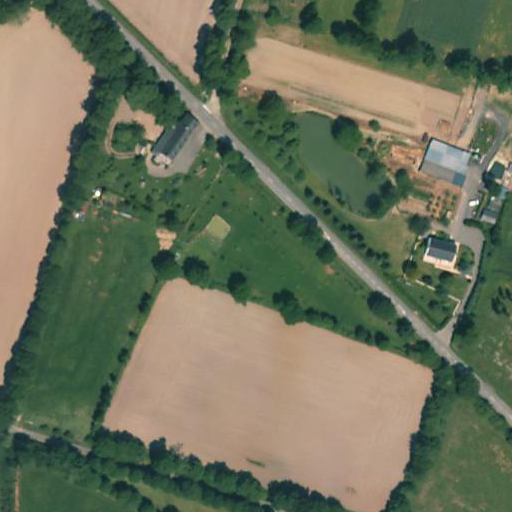

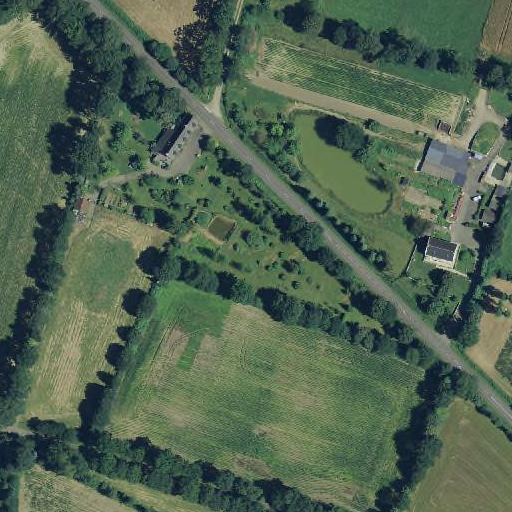

In [16]:
preimagepath='change/t1'
postimagepath = 'change/t2'
count=1
currentim = '/img_' + str(count) + '.tif'

t1im=cv.imread(preimagepath + currentim )
t2im=cv.imread(postimagepath + currentim )
show(t1im)
show(t2im)

In [4]:

'''
#Reading Image
try:
    inputDataContents=sio.loadmat(dataPath)
    preChangeImage=inputDataContents['preChangeImage']
    postChangeImage=inputDataContents['postChangeImage']
except:
    sys.exit('Cannot read the file. Check if it is a valid .mat file with both pre-change (variable preChangeImage) and post-change data (variable postChangeImage)')
'''
preimagepath  = 'change/t1'
postimagepath = 'change/t2'
for imcount in range(1,2) :

    currentim = '/img_' + str(imcount) + '.tif'
    print("I'm at " + str(imcount) + ".image")
    try:
        preChangeImage  = cv.imread(preimagepath + currentim ) / 255
        postChangeImage = cv.imread(postimagepath + currentim ) / 255
    except:
        sys.exit('Cannot read the file. Check if it is a valid .mat file with both pre-change (variable preChangeImage) and post-change data (variable postChangeImage)')

    if use_masking:
      mask = change_detector(preChangeImage,postChangeImage)

      preChangeImage[:,:,0] =  preChangeImage[:,:,0] * mask
      preChangeImage[:,:,1] =  preChangeImage[:,:,1] * mask
      preChangeImage[:,:,2] =  preChangeImage[:,:,2] * mask

      postChangeImage[:,:,0]= postChangeImage[:,:,0] * mask
      postChangeImage[:,:,1]= postChangeImage[:,:,1] * mask
      postChangeImage[:,:,2]= postChangeImage[:,:,2] * mask

    #Pre-change and post-change image normalization
    if topPercentSaturationOfImageOk:
        preChangeImageNormalized=saturateImage().saturateSomePercentileMultispectral(preChangeImage, topPercentToSaturate)
        postChangeImageNormalized=saturateImage().saturateSomePercentileMultispectral(postChangeImage, topPercentToSaturate)
        


    #Reassigning pre-change and post-change image to normalized values
    data1=np.copy(preChangeImageNormalized)
    data2=np.copy(postChangeImageNormalized)

    #Checking image dimension
    imageSize=data1.shape
    imageSizeRow=imageSize[0]
    imageSizeCol=imageSize[1]
    imageNumberOfChannel=imageSize[2]

    if imageSizeRow!=imageSizeCol:
        sys.exit('This code is written for square images. However, code can be easily modified for images with other aspect ratio, however this is\
    not provided here. or the image can be resized to square size')


    #Initilizing net / model (G_B: acts as feature extractor here)
    input_nc=imageNumberOfChannel #input number of channels
    output_nc=6 #from Potsdam dataset number of classes
    ngf=64 # number of gen filters in first conv layer
    norm_layer = nn.BatchNorm2d
    use_dropout=False



    netForFeatureExtractionLayer23=ResnetFeatureExtractor9FeatureFromLayer23(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    netForFeatureExtractionLayer11=ResnetFeatureExtractor9FeatureFromLayer11(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    netForFeatureExtractionLayer10=ResnetFeatureExtractor9FeatureFromLayer10(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    netForFeatureExtractionLayer8=ResnetFeatureExtractor9FeatureFromLayer8(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    netForFeatureExtractionLayer5=ResnetFeatureExtractor9FeatureFromLayer5(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    netForFeatureExtractionLayer2=ResnetFeatureExtractor9FeatureFromLayer2(input_nc, output_nc, ngf, norm_layer, use_dropout, 9)
    
    if inputChannels=='RGB':
        state_dict=torch.load('trainedNet/RGB/trainedModelFinal')
        if imageNumberOfChannel!=3:
            sys.exit('Input images do not have 3 channels while loaded model is for R-G-B input')    
    else:
        sys.exit('Image channels not valid - valid arguments RGB or RGBNIR')

    state_dict=torch.load('trainedNet/RGB/trainedModelFinal') 

    #for name, param in state_dict.items():
    #    print(name)

    netForFeatureExtractionLayer23Dict=netForFeatureExtractionLayer23.state_dict()
    state_dictForLayer23=state_dict
    state_dictForLayer23={k: v for k, v in netForFeatureExtractionLayer23Dict.items() if k in state_dictForLayer23}

    netForFeatureExtractionLayer11Dict=netForFeatureExtractionLayer11.state_dict()
    state_dictForLayer11=state_dict
    state_dictForLayer11={k: v for k, v in netForFeatureExtractionLayer11Dict.items() if k in state_dictForLayer11}

    netForFeatureExtractionLayer10Dict=netForFeatureExtractionLayer10.state_dict()
    state_dictForLayer10=state_dict
    state_dictForLayer10={k: v for k, v in netForFeatureExtractionLayer10Dict.items() if k in state_dictForLayer10}

    netForFeatureExtractionLayer8Dict=netForFeatureExtractionLayer8.state_dict()
    state_dictForLayer8=state_dict
    state_dictForLayer8={k: v for k, v in netForFeatureExtractionLayer8Dict.items() if k in state_dictForLayer8}

    netForFeatureExtractionLayer5Dict=netForFeatureExtractionLayer5.state_dict()
    state_dictForLayer5=state_dict
    state_dictForLayer5={k: v for k, v in netForFeatureExtractionLayer5Dict.items() if k in state_dictForLayer5}

    netForFeatureExtractionLayer2Dict=netForFeatureExtractionLayer2.state_dict()
    state_dictForLayer2=state_dict
    state_dictForLayer2={k: v for k, v in netForFeatureExtractionLayer2Dict.items() if k in state_dictForLayer2}

    netForFeatureExtractionLayer23.load_state_dict(state_dictForLayer23)
    netForFeatureExtractionLayer11.load_state_dict(state_dictForLayer11)
    netForFeatureExtractionLayer10.load_state_dict(state_dictForLayer10)
    netForFeatureExtractionLayer8.load_state_dict(state_dictForLayer8)
    netForFeatureExtractionLayer5.load_state_dict(state_dictForLayer5)
    netForFeatureExtractionLayer2.load_state_dict(state_dictForLayer2)


    input_nc=imageNumberOfChannel #input number of channels
    output_nc=imageNumberOfChannel #output number of channels
    ngf=64 # number of gen filters in first conv layer
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    use_dropout=False



    ##changing all nets to eval mode
    netForFeatureExtractionLayer23.eval()
    netForFeatureExtractionLayer23.requires_grad=False

    netForFeatureExtractionLayer11.eval()
    netForFeatureExtractionLayer11.requires_grad=False

    netForFeatureExtractionLayer10.eval()
    netForFeatureExtractionLayer10.requires_grad=False

    netForFeatureExtractionLayer8.eval()
    netForFeatureExtractionLayer8.requires_grad=False

    netForFeatureExtractionLayer5.eval()
    netForFeatureExtractionLayer5.requires_grad=False

    netForFeatureExtractionLayer2.eval()
    netForFeatureExtractionLayer2.requires_grad=False


    torch.no_grad()


    eachPatch=imageSizeRow
    numImageSplitRow=imageSizeRow/eachPatch
    numImageSplitCol=imageSizeCol/eachPatch
    cutY=list(range(0,imageSizeRow,eachPatch))
    cutX=list(range(0,imageSizeCol,eachPatch))
    additionalPatchPixel=64


    layerWiseFeatureExtractorFunction=[nanVar,nanVar,netForFeatureExtractionLayer2,nanVar,nanVar,netForFeatureExtractionLayer5,nanVar,nanVar,netForFeatureExtractionLayer8,nanVar,\
                                netForFeatureExtractionLayer10,netForFeatureExtractionLayer11,nanVar,nanVar,nanVar,nanVar,nanVar,nanVar,nanVar,nanVar,\
                                nanVar,nanVar,nanVar,netForFeatureExtractionLayer23,nanVar,nanVar,nanVar,nanVar]

    

    ##Checking validity of feature extraction layers
    validFeatureExtractionLayers=[2,5,8,10,11,23] ##Feature extraction from only these layers have been defined here
    for outputLayer in outputLayerNumbers:
        if outputLayer not in validFeatureExtractionLayers:
            sys.exit('Feature extraction layer is not valid, valid values are 2,5,8,10,11,23')
            
    ##Extracting bi-temporal features
    modelInputMean=0.406
    for outputLayerIter in range(0,len(outputLayerNumbers)):
        outputLayerNumber=outputLayerNumbers[outputLayerIter]
        filterNumberForOutputLayer=filterNumberTable[outputLayerNumber]
        featurePercentileToDiscard=featurePercentileToDiscardTable[outputLayerNumber]
        featureNumberToRetain=int(np.floor(filterNumberForOutputLayer*((100-featurePercentileToDiscard)/100)))
        sizeReductionForOutputLayer=sizeReductionTable[outputLayerNumber]
        patchOffsetFactor=int(additionalPatchPixel/sizeReductionForOutputLayer)
        print('Processing layer number:'+str(outputLayerNumber))
        
        timeVector1Feature=np.zeros([imageSizeRow,imageSizeCol,filterNumberForOutputLayer])
        timeVector2Feature=np.zeros([imageSizeRow,imageSizeCol,filterNumberForOutputLayer])
        for kY in range(0,len(cutY)):
            for kX in range(0,len(cutX)):
                
                #extracting subset of image 1
                if (kY==0 and kX==0):
                    patchToProcessDate1=data1[cutY[kY]:(cutY[kY]+eachPatch+additionalPatchPixel),\
                                                cutX[kX]:(cutX[kX]+eachPatch+additionalPatchPixel),:]
                elif kY==0:
                    patchToProcessDate1=data1[cutY[kY]:(cutY[kY]+eachPatch+additionalPatchPixel),\
                                                (cutX[kX]-additionalPatchPixel):(cutX[kX]+eachPatch),:]
                elif kX==0:
                    patchToProcessDate1=data1[(cutY[kY]-additionalPatchPixel):\
                                            (cutY[kY]+eachPatch),\
                                                cutX[kX]:(cutX[kX]+eachPatch+additionalPatchPixel),:]
                else:
                    patchToProcessDate1=data1[(cutY[kY]-additionalPatchPixel):\
                                            (cutY[kY]+eachPatch),\
                                            (cutX[kX]-additionalPatchPixel):(cutX[kX]+eachPatch),:]
                #extracting subset of image 2   
                if (kY==0 and kX==0):
                    patchToProcessDate2=data2[cutY[kY]:(cutY[kY]+eachPatch+additionalPatchPixel),\
                                                cutX[kX]:(cutX[kX]+eachPatch+additionalPatchPixel),:]
                elif kY==0:
                    patchToProcessDate2=data2[cutY[kY]:(cutY[kY]+eachPatch+additionalPatchPixel),\
                                                (cutX[kX]-additionalPatchPixel):(cutX[kX]+eachPatch),:]
                elif kX==0:
                    patchToProcessDate2=data2[(cutY[kY]-additionalPatchPixel):\
                                            (cutY[kY]+eachPatch),\
                                                cutX[kX]:(cutX[kX]+eachPatch+additionalPatchPixel),:]
                else:
                    patchToProcessDate2=data2[(cutY[kY]-additionalPatchPixel):\
                                            (cutY[kY]+eachPatch),\
                                            (cutX[kX]-additionalPatchPixel):(cutX[kX]+eachPatch),:]
            
                #converting to pytorch varibales and changing dimension for input to net
                patchToProcessDate1=patchToProcessDate1-modelInputMean
                
                inputToNetDate1=torch.from_numpy(patchToProcessDate1)
                inputToNetDate1=inputToNetDate1.float()
                inputToNetDate1=np.swapaxes(inputToNetDate1,0,2)
                inputToNetDate1=np.swapaxes(inputToNetDate1,1,2)
                inputToNetDate1=inputToNetDate1.unsqueeze(0)
                
                
                patchToProcessDate2=patchToProcessDate2-modelInputMean
                
                inputToNetDate2=torch.from_numpy(patchToProcessDate2)
                inputToNetDate2=inputToNetDate2.float()
                inputToNetDate2=np.swapaxes(inputToNetDate2,0,2)
                inputToNetDate2=np.swapaxes(inputToNetDate2,1,2)
                inputToNetDate2=inputToNetDate2.unsqueeze(0)
                
                
                #running model on image 1 and converting features to numpy format
                
                with torch.no_grad():
                    obtainedFeatureVals1=layerWiseFeatureExtractorFunction[outputLayerNumber](inputToNetDate1)
                obtainedFeatureVals1=obtainedFeatureVals1.squeeze()
                obtainedFeatureVals1=obtainedFeatureVals1.data.numpy()
                
                #running model on image 2 and converting features to numpy format
                with torch.no_grad():
                    obtainedFeatureVals2=layerWiseFeatureExtractorFunction[outputLayerNumber](inputToNetDate2)
                obtainedFeatureVals2=obtainedFeatureVals2.squeeze()
                obtainedFeatureVals2=obtainedFeatureVals2.data.numpy()
                #this features are in format (filterNumber, sizeRow, sizeCol)
                
                
                ##clipping values to +1 to -1 range, be careful, if network is changed, maybe we need to modify this
                obtainedFeatureVals1=np.clip(obtainedFeatureVals1,-1,+1)
                obtainedFeatureVals2=np.clip(obtainedFeatureVals2,-1,+1)
                
                
                #obtaining features from image 1: resizing and truncating additionalPatchPixel
                if (kY==0 and kX==0):
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector1Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals1[processingFeatureIter,\
                                                                0:int(eachPatch/sizeReductionForOutputLayer),\
                                                                0:int(eachPatch/sizeReductionForOutputLayer)],\
                                                                (eachPatch,eachPatch))
                    
                elif kY==0:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector1Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals1[processingFeatureIter,\
                                                                0:int(eachPatch/sizeReductionForOutputLayer),\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor)],\
                                                                (eachPatch,eachPatch))
                elif kX==0:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector1Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals1[processingFeatureIter,\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor),\
                                                                0:int(eachPatch/sizeReductionForOutputLayer)],\
                                                                (eachPatch,eachPatch))
                else:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector1Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals1[processingFeatureIter,\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor),\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor)],\
                                                                (eachPatch,eachPatch))
                #obtaining features from image 2: resizing and truncating additionalPatchPixel
                if (kY==0 and kX==0):
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector2Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals2[processingFeatureIter,\
                                                                0:int(eachPatch/sizeReductionForOutputLayer),\
                                                                0:int(eachPatch/sizeReductionForOutputLayer)],\
                                                                (eachPatch,eachPatch))
                    
                elif kY==0:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector2Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals2[processingFeatureIter,\
                                                                0:int(eachPatch/sizeReductionForOutputLayer),\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor)],\
                                                                (eachPatch,eachPatch))
                elif kX==0:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector2Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals2[processingFeatureIter,\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor),\
                                                                0:int(eachPatch/sizeReductionForOutputLayer)],\
                                                                (eachPatch,eachPatch))
                else:
                    for processingFeatureIter in range(0,filterNumberForOutputLayer):
                        timeVector2Feature[cutY[kY]:(cutY[kY]+eachPatch),\
                                    cutX[kX]:(cutX[kX]+eachPatch),processingFeatureIter]=\
                                    resize(obtainedFeatureVals2[processingFeatureIter,\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor),\
                                                                (patchOffsetFactor):\
                                                                (int(eachPatch/sizeReductionForOutputLayer)+patchOffsetFactor)],\
                                                                (eachPatch,eachPatch))
                                    
                                    

        ##Modification by layer selection is removed                 
        modifiedTimeVector1=timeVector1Feature
        modifiedTimeVector2=timeVector2Feature
        
        normalizedModifiedTimeVector1 = timeVector1Feature
        normalizedModifiedTimeVector2 = timeVector2Feature

     
        
        ##feature aggregation across channels
        if outputLayerIter==0:
            timeVector1FeatureAggregated=np.copy(normalizedModifiedTimeVector1)
            timeVector2FeatureAggregated=np.copy(normalizedModifiedTimeVector2)
        else:
            timeVector1FeatureAggregated=np.concatenate((timeVector1FeatureAggregated,normalizedModifiedTimeVector1),axis=2)
            timeVector2FeatureAggregated=np.concatenate((timeVector2FeatureAggregated,normalizedModifiedTimeVector2),axis=2)
        
        

    
    del obtainedFeatureVals1, obtainedFeatureVals2, timeVector1Feature, timeVector2Feature, inputToNetDate1, inputToNetDate2 
    del netForFeatureExtractionLayer5, netForFeatureExtractionLayer8, netForFeatureExtractionLayer10, netForFeatureExtractionLayer11,netForFeatureExtractionLayer23   


    ModifiedTimeVectorDifference = timeVector1FeatureAggregated-timeVector2FeatureAggregated
    sh = ModifiedTimeVectorDifference.shape
    if use_max_pool:
      
      temp    = ModifiedTimeVectorDifference.reshape(sh[0]*sh[1],sh[2]) 
      indices = np.argsort(abs(temp),axis=0)

      sorted_diff = np.take_along_axis(temp, indices, axis = 0) 

      for feature_i in range(1,k+1):
        f = sorted_diff[-1*feature_i:,:].flatten()

        with open("features/pooled/f_pooled" + str(feature_i) + '_' + str(imcount) + '.csv', 'w') as file:
          write = csv.writer(file)      
          write.writerow(f)
      
    
                
    if use_hist:
      for channel in range(0,sh[2]):

        current  = ModifiedTimeVectorDifference[:,:,channel].flatten()
        amax_val = max(current.min(), current.max(), key=abs)
        current  = current / amax_val 
        hist , _ = np.histogram(current, bins = n_bins, range = (-1,1))
        
        if channel == 0:
          hist_feature = np.copy(hist)
        else :
          hist_feature = np.concatenate((hist_feature,hist))
      
      np.savetxt("features/hist/f_hist" +  str(imcount) + '.csv' , hist_feature, delimiter= ',' )

    #Each feature is saved seperately to prevent crashing  
    print("Next image") 


I'm at 1.image
Processing layer number:2
Processing layer number:8
Processing layer number:23
Processing layer number:2
Processing layer number:5
Processing layer number:8
Next image


In [13]:
if 1 :
  print("Me")

Me
